<a href="https://colab.research.google.com/github/keedjk7/Machine-Learning/blob/main/Activity9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn.neural_network import MLPClassifier
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf
from sklearn.model_selection import train_test_split

#9.1.1

##9.1(a) Load and Prepare Data

In [ ]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('/content/drive/MyDrive/Colab Data/acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('/content/drive/MyDrive/Colab Data/heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('/content/drive/MyDrive/Colab Data/labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [ ]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()


print('ACC start: ',ACC_min_date ,'ACC end: ',ACC_max_date)
print('HeartR start: ',HeartR_min_date ,'HeartR end: ',HeartR_max_date)
print('SleepL start: ',SleepL_min_date ,'SleepL end: ',SleepL_max_date)

ACC start:  97.0 ACC end:  17643.046417
HeartR start:  -556410.36066 HeartR end:  16980.47229
SleepL start:  0 SleepL end:  16980


In [ ]:
#set start timedelta
start_timedelta = 0
#set end timedelta
end_timedelta = 16980

ACC_new = ACC[(ACC['timedelta'] >= start_timedelta) &(ACC['timedelta'] <= end_timedelta) ]
HeartR_new = HeartR[(HeartR['timedelta'] >= start_timedelta) &(HeartR['timedelta'] <= end_timedelta) ]
SleepL_new = SleepL[(SleepL['timedelta'] >= start_timedelta) &(SleepL['timedelta'] <= end_timedelta) ]

In [ ]:
ACC_new

,timedelta,accX,accY,accZ
0,97.000000,0.914566,NaN,NaN
1,1218.423666,-0.256088,-0.303055,0.913590
2,1218.443521,-0.257050,-0.304062,0.911636
3,1218.463597,-0.255585,-0.303543,0.913590
4,1218.483556,-0.256073,-0.302094,0.912125
...,...,...,...,...
788976,16979.905934,-0.442413,-0.527573,0.723450
788977,16979.925889,-0.441925,-0.527573,0.721985
788978,16979.945849,-0.441437,-0.526108,0.721985
788979,16979.965927,-0.443405,-0.525116,0.723434


##9.1(b) Load and Prepare Data (ACC)

In [ ]:
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))

#เวลาที่ duplicate ให้ปัดเป็น mean 
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

ACC_new2 = pd.concat([df_acc_X, df_acc_Y['accY'], df_acc_Z['accZ']], axis=1)
ACC_new2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,timedelta,accX,accY,accZ
0,0 days 00:01:37,0.914566,NaN,NaN
1,0 days 00:20:18,-0.256199,-0.303188,0.912735
2,0 days 00:20:19,-0.256069,-0.302910,0.912509
3,0 days 00:20:20,-0.255648,-0.302149,0.912890
4,0 days 00:20:21,-0.255845,-0.302151,0.912779
...,...,...,...,...
15759,0 days 04:42:56,-0.442763,-0.525892,0.722950
15760,0 days 04:42:57,-0.441990,-0.525476,0.723410
15761,0 days 04:42:58,-0.441581,-0.525116,0.724003
15762,0 days 04:42:59,-0.442283,-0.525849,0.723265


##9.1 (c) Load and Prepare Data (Heart rate)

In [ ]:
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


##9.1 (d) Load and Prepare Data (Sleep Label)

In [ ]:
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:00,-1.0
0 days 00:00:01,-1.0
0 days 00:00:02,-1.0
0 days 00:00:03,-1.0
0 days 00:00:04,-1.0
...,...
0 days 04:42:56,0.0
0 days 04:42:57,0.0
0 days 04:42:58,0.0


##9.1(e) Merge Data and Standardized data

In [ ]:
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')

In [ ]:
count_check =df.isnull().sum()
count_check

timedelta    0
accX         0
accY         1
accZ         1
heartrate    0
sleep        0
dtype: int64

In [ ]:
fillAccX= df['accX'].median()
df['accX']=df['accX'].fillna(fillAccX)
fillAccY = df['accY'].median()
df['accY']=df['accY'].fillna(fillAccY)
fillAccZ = df['accZ'].median()
df['accZ']=df['accZ'].fillna(fillAccY)
fillHeartRate = df['heartrate'].median()
df['heartrate']=df['heartrate'].fillna(fillHeartRate)
fillSleep = df['sleep'].median()
df['sleep']=df['sleep'].fillna(fillSleep)

In [ ]:
re_check =df.isnull().sum()
re_check

timedelta    0
accX         0
accY         0
accZ         0
heartrate    0
sleep        0
dtype: int64

In [ ]:
df = df.drop(columns = ['timedelta'])
df

,accX,accY,accZ,heartrate,sleep
0,0.914566,-0.132058,-0.132058,84.0,-1.0
1,-0.256199,-0.303188,0.912735,85.0,0.0
2,-0.256069,-0.302910,0.912509,85.0,0.0
3,-0.255648,-0.302149,0.912890,85.0,0.0
4,-0.255845,-0.302151,0.912779,88.0,0.0
...,...,...,...,...,...
15759,-0.442763,-0.525892,0.722950,76.0,0.0
15760,-0.441990,-0.525476,0.723410,76.0,0.0
15761,-0.441581,-0.525116,0.724003,76.0,0.0
15762,-0.442283,-0.525849,0.723265,76.0,0.0


In [ ]:
feature_columns = ['accX','accY','accZ','heartrate']
label_columns = ['sleep']

df_feature = df[feature_columns]
df_label = df[label_columns]
#standardized
standard_scaler = StandardScaler()
afterScaler = standard_scaler.fit_transform(df_feature)

afterScaler

array([[ 2.20608726,  0.10679683,  0.14514424,  0.46065692],
       [-0.6599218 , -0.42288241,  1.45326813,  0.58966149],
       [-0.65960312, -0.42202237,  1.45298498,  0.58966149],
       ...,
       [-1.11373226, -1.10978677,  1.21696745, -0.57137957],
       [-1.11545123, -1.11205754,  1.21604355, -0.57137957],
       [-1.11640897, -1.1124061 ,  1.2153084 , -0.57137957]])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6a3924ffd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a39185410>)

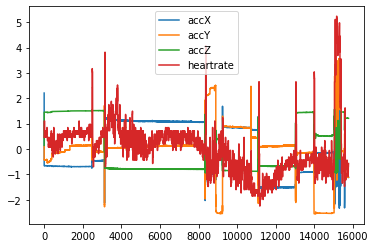

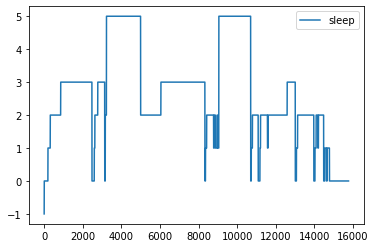

In [ ]:
df_feature = pd.DataFrame(data = afterScaler, index = df_feature.index, columns = feature_columns)

df_feature.plot(), df_label.plot()

#9.1.2 Train Test Split

In [ ]:
Rseed = 42
x_train_set, x_test, y_train_set, y_test = train_test_split(df_feature, df_label, test_size = 0.3, random_state = Rseed)
x_train, x_validate, y_train, y_validate = train_test_split(x_train_set, y_train_set, test_size = 0.3, random_state = Rseed)

#9.2 NN Model Train and Test

###NN Model Train Test

In [ ]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30)
#create object model(Multi-layer Perceptron classifier.)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
# View NN model parameters

In [ ]:
# ------------ Training NN using 1D features -------------------------------
mlp.fit(x_train,y_train)
mlp_pred = mlp.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
#View Confusion Matrix and Classification Report
print('Confusion Matrix')
confusion_matrix(y_test,mlp_pred)

Confusion Matrix


array([[   0,    1,    0,    0,    0,    0],
       [   0,  424,   36,   26,   17,    1],
       [   0,   66,  114,   86,    4,    3],
       [   0,  115,   43, 1219,   79,   60],
       [   0,    6,    0,   62, 1332,    0],
       [   0,    0,    6,   20,    0, 1010]])

In [ ]:
print('Classification RBF')
print(classification_report(y_test,mlp_pred))

Classification RBF
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         1
         0.0       0.69      0.84      0.76       504
         1.0       0.57      0.42      0.48       273
         2.0       0.86      0.80      0.83      1516
         3.0       0.93      0.95      0.94      1400
         5.0       0.94      0.97      0.96      1036

    accuracy                           0.87      4730
   macro avg       0.67      0.66      0.66      4730
weighted avg       0.86      0.87      0.86      4730



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##9.3.1CNN Model Train and Test

In [ ]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
Activation = "relu"
Ker_size = (3,3)
Pooling_size = (2,1)
slidingW = 100
n_feature = 4
Input_shape = (slidingW, n_feature, 1)

In [ ]:
# ------------ Create CNN Model -------------------------------
model= Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Activation,input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation= Activation,padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(D_L1 , activation= Activation ))
model.add(Dense(D_out, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 4, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 4, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 4, 64)        

In [ ]:
# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=["acc"])

In [ ]:
#split train test 3d
Stride_step = 5
df_feature3D = np.array([],ndmin=2)
df_label_new = np.array([])

for t in range(0 , len(df_feature), Stride_step ):
    F3d = np.array(df_feature[t:t+slidingW],ndmin=2)
    if len(F3d) <slidingW:
        break
    F3d.reshape(slidingW, n_feature,1)
    if df_feature3D.size == 0 :
        df_feature3D = F3d
    else:
        df_feature3D = np.dstack((df_feature3D,F3d))
    Labels = stats.mode(df_label[t : t+slidingW])
    df_label_new = np.append(df_label_new,Labels[0])

df_feature3D = np.swapaxes(df_feature3D,0,2)
df_feature3D = np.swapaxes(df_feature3D,1,2)
df_feature3D = df_feature3D[..., np.newaxis]
x3D_train, x3D_test, y3D_train, y3D_test = train_test_split( df_feature3D , df_label_new,test_size = 0.33 ,random_state=2)

In [ ]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,
validation_data=(x3D_test, y3D_test))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 5s 131ms/step - loss: 1.1239 - acc: 0.5145 - val_loss: 0.8483 - val_acc: 0.6731
Epoch 2/50
33/33 [==============================] - 4s 126ms/step - loss: 0.7320 - acc: 0.6670 - val_loss: 0.6753 - val_acc: 0.7099
Epoch 3/50
33/33 [==============================] - 4s 126ms/step - loss: 0.5691 - acc: 0.7480 - val_loss: 0.5301 - val_acc: 0.7901
Epoch 4/50
33/33 [==============================] - 4s 125ms/step - loss: 0.5134 - acc: 0.7866 - val_loss: 0.5517 - val_acc: 0.8182
Epoch 5/50
33/33 [==============================] - 4s 124ms/step - loss: 0.4758 - acc: 0.8104 - val_loss: 0.4910 - val_acc: 0.7892
Epoch 6/50
33/33 [==============================] - 4s 126ms/step - loss: 0.4178 - acc: 0.8290 - val_loss: 0.4373 - val_acc: 0.8317
Epoch 7/50
33/33 [==============================] - 4s 124ms/step - loss: 0.4008 - acc: 0.8294 - val_loss: 0.4485 - val_acc: 0.8259
Epoch 8/50
33/33 [==============================] - 4s 126ms/step - loss: 0.3821 - acc:

In [ ]:
# ------- Test CNN -------------------------------
CNN_pred = model.predict(x3D_test)

33/33 [==============================] - 1s 28ms/step


##Performnace of CNN Model

In [ ]:
#View Confusion Matrix and Classification Report
print('Confusion Matrix')
confusion_matrix(y_test,mlp_pred)

Confusion Matrix


array([[   0,    1,    0,    0,    0,    0],
       [   0,  424,   36,   26,   17,    1],
       [   0,   66,  114,   86,    4,    3],
       [   0,  115,   43, 1219,   79,   60],
       [   0,    6,    0,   62, 1332,    0],
       [   0,    0,    6,   20,    0, 1010]])

In [ ]:
print('Classification RBF')
print(classification_report(y_test,mlp_pred))

Classification RBF
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         1
         0.0       0.69      0.84      0.76       504
         1.0       0.57      0.42      0.48       273
         2.0       0.86      0.80      0.83      1516
         3.0       0.93      0.95      0.94      1400
         5.0       0.94      0.97      0.96      1036

    accuracy                           0.87      4730
   macro avg       0.67      0.66      0.66      4730
weighted avg       0.86      0.87      0.86      4730



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


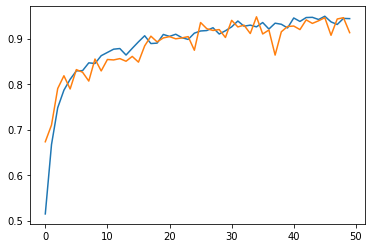

In [ ]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

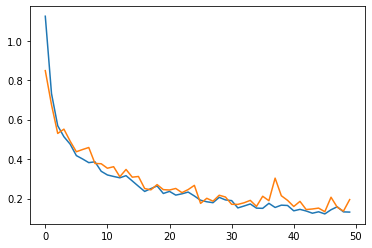

In [ ]:
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()